# VGG16 迁移学习
1. 处理图片，下载cats_and_dogs_filtered数据集
2. 打造训练数据集、验证数据集
3. 下载VGG16已经有的模型结构和权重
4. 构造自己的数据输入和输出的网络结构
5. 进行训练、评估

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## 一、下载数据集
下载tensorflow示例的数据集，这个数据集包含猫和狗的3000张照片其中训练集中2000张，验证集中1000张，我们在下载完数据集之后，构造训练集和验证集

In [13]:
# _URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
# path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
# PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

# train_dir = os.path.join(PATH, 'train')
# validation_dir = os.path.join(PATH, 'validation')
data_dir = "F:\dataset\散热器"
batch_size = 32
img_height = 180
img_width = 180
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                        data_dir,
                        validation_split=0.2,
                        subset="training",
                        seed=123,
                        image_size=(180, 180),
                        batch_size=batch_size)

Found 260 files belonging to 2 classes.
Using 208 files for training.


In [14]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                        data_dir,
                        validation_split=0.2,
                        subset="validation",
                        seed=123,
                        image_size=(180, 180),
                        batch_size=batch_size)

Found 260 files belonging to 2 classes.
Using 52 files for validation.


对下载数据集进行构造

In [15]:
class_names = train_dataset.class_names

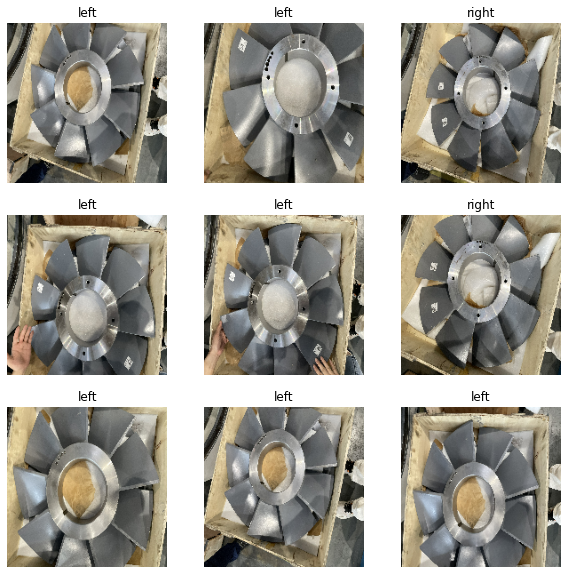

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## 二、下载VGG16的模型和权重

In [17]:
base_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet')

In [18]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

确定调优的层数，对其他层进行冻结

In [19]:
print(len(base_model.layers))

19


In [20]:
fine_tune_at = 16
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [21]:
print(len(base_model.trainable_variables))

4


## 三、编写自定义的输入层和输出层

In [23]:
Input = tf.keras.Input(shape=(180, 180, 3))
x = base_model(Input)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(.2)(x)
Output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(Input, Output)

定义损失函数，优化器，编译模型

In [24]:
base_learning_rate = 0.000001
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
opt = tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
model.compile(optimizer=opt,
             loss=loss,
             metrics=['accuracy'])

## 四、训练模型

In [ ]:
initial_epochs = 20
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20
7/7 [==============================] - 47s 2s/step - loss: 6.3062 - accuracy: 0.3285 - val_loss: 4.7657 - val_accuracy: 0.4038
Epoch 2/20
7/7 [==============================] - 22s 727ms/step - loss: 4.2064 - accuracy: 0.4530 - val_loss: 3.4365 - val_accuracy: 0.4038
Epoch 3/20
7/7 [==============================] - 17s 728ms/step - loss: 3.4238 - accuracy: 0.4974 - val_loss: 2.5870 - val_accuracy: 0.4038
Epoch 4/20


## 对模型进行评估描述

In [42]:
loss, accuracy = model.evaluate(validation_dataset)
print(accuracy)

2/2 [==============================] - 3s 88ms/step - loss: 0.1329 - accuracy: 0.9423
0.942307710647583


Predictions:
 [0 0 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0]
Labels:
 [0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0]


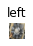

In [43]:
image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(1, 1))
for i in range(1):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

IndexError: invalid index to scalar variable.

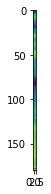

In [46]:
plt.figure(figsize=(10, 10))
for images, labels in zip(image_batch, label_batch):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

* 附录：
数据增强


定义增强的操作流程

In [25]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

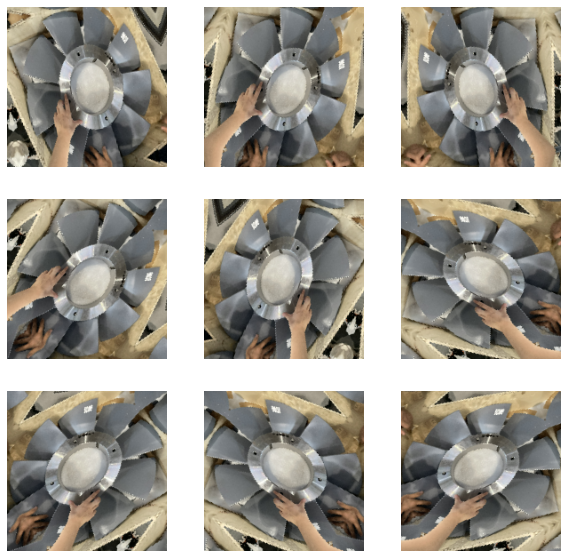

In [26]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')